In [1]:
%pylab inline
from utils import *
from ipdb import set_trace
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
# from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
# from ADNI_dataset import *
from BRATS_dataset import *
# from ATLAS_dataset import *
from Model_alphaWGAN import *
# from Model_VAEGAN import Encoder
from utils import sinkhorn_pointcloud as sp

Populating the interactive namespace from numpy and matplotlib


# Configuration

In [2]:
BATCH_SIZE=4
TEST_BATCH_SIZE=8
gpu = True
workers = 4

LAMBDA= 10
_eps = 1e-15
Use_BRATS = True
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

gpu_0 = 0
gpu_1 = 0
torch_seed = 4
r_g = torch.manual_seed(torch_seed)
checkpoint_pth = 'brats_cce_checkpoint_4/'

In [3]:
# dataset = ADNIdataset(augmentation=True, img_size=64)
# trainset = BRATSdataset(train=True, augmentation=True)
# testset = BRATSdataset(train=False, augmentation=True)
# trainset, testset = data.random_split(dataset, [5, 5], generator=r_g)
# train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)
# test_loader = torch.utils.data.DataLoader(testset,batch_size=TEST_BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)
if Use_BRATS:
    #'flair' or 't2' or 't1ce'
    trainset = BRATSdataset(imgtype='flair')
    train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
                                               num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [4]:
G = Generator(noise = latent_dim)
D = Discriminator(is_dis=True)
# E = Encoder(gpu_ind=gpu_0)
E = Discriminator(out_class = latent_dim,is_dis=False, img_size=128)

G.cuda(gpu_0)
D.cuda(gpu_0)
E.cuda(gpu_1)

Discriminator(
  (conv1): Conv3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (conv2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn4): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv3d(512, 1000, kernel_size=(4, 4, 4), stride=(1, 1, 1))
)

In [5]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr=0.0002)

# Training

In [6]:
# torch.autograd.set_detect_anomaly(True)
#remove Variable usage
# real_y = torch.ones((BATCH_SIZE, 1)).cuda()#async=True))
# fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()#async=True))

# criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [7]:
# load the highest savepoints of all models
df = load_loss(path=checkpoint_pth)
iteration = load_checkpoint(G, D, E, None, '_iter', path=checkpoint_pth)

In [8]:
g_iter = 1
d_iter = 3
TOTAL_ITER = 200000
gen_load = inf_train_gen(train_loader)

lossStr [0/200000]
        D: -15.7   
        En_Ge: 1.4e+02 


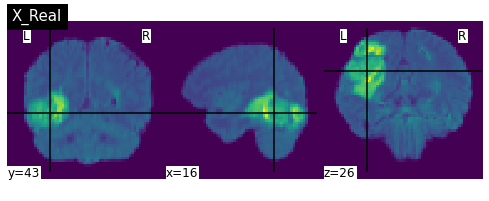

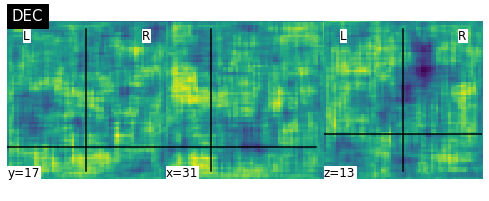

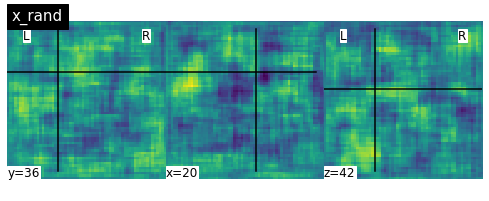

In [ ]:
while iteration <= TOTAL_ITER:
    for p in D.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters():  
        p.requires_grad = True
        
    ######i#########################################
    # Train Encoder - Generator 
    ###############################################
    for iters in range(g_iter):
        real_images = gen_load.__next__().cuda(gpu_0)
        _batch_size = real_images.size(0)
        if not _batch_size == BATCH_SIZE: 
            break
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        
        d_recon_loss = D(x_hat).mean()
        d_fake_loss = D(x_rand).mean()
        l1_loss = 100 * criterion_l1(x_hat.cuda(gpu_1),real_images)
        ### L2 loss(MSE loss) for reconstruction of the Encoder 
        z_ee, z_re = E(x_hat), E(x_rand)
        z_e_l2, z_r_l2 = 50 * criterion_mse(z_hat, z_ee), 50 * criterion_mse(z_rand, z_re)
        ###############################################
        loss1 = l1_loss - d_fake_loss - d_recon_loss + z_e_l2 + z_r_l2 
        
        G.zero_grad()
        E.zero_grad()
        if iters<g_iter-1:
            loss1.backward()
        else:
            loss1.backward(retain_graph=True)
        g_optimizer.step()
        g_optimizer.step()
        
    
    for p in D.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters(): 
        p.requires_grad = False
    for iters in range(g_iter):
        z_rand = torch.randn((_batch_size,latent_dim)).cuda(gpu_0)
        z_hat = E(real_images).view(_batch_size,-1)
        ### wasserstein loss between z_e and z_r ###################
        w_dist = 100 * sp.sinkhorn_loss(torch.transpose(z_rand, 0, 1), torch.transpose(z_hat, 0, 1), 0.1, 1000, 100, gpu=gpu_0)
#         var_loss = torch.mean(torch.pow(torch.var(z_rand, dim=1) - torch.var(z_hat, dim=1), 2))
        ###############################################
        
        e_loss = w_dist
        E.zero_grad()
        if iters<g_iter-1:
            e_loss.backward()
        else:
            e_loss.backward(retain_graph=True)
        e_optimizer.step()
        
        
    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False
        
    for iters in range(d_iter):
        d_optimizer.zero_grad()
        real_images = gen_load.__next__().cuda(gpu_0)
        _batch_size = real_images.size(0)
        
        if not _batch_size == BATCH_SIZE: 
            break
            
        x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
        gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand, cuda_ind=gpu_1)
        gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat, cuda_ind=gpu_1)
        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
#         if iters < d_iter - 1:
#             loss2.backward(retain_graph=True)
#         else:
        loss2.backward(retain_graph=True)
        d_optimizer.step()
        
    ###############################################
    # Visualization
    ###############################################

    if iteration % 500 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(loss2.item()) + '\n\
        En_Ge: {:<8.3}'.format(loss1.item())
        
        print('lossStr', lossStr)
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

        feat = np.squeeze((0.5*x_hat[0]+0.5).detach().cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        
        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        
    ###############################################
    # Save the losses
    ###############################################
    loss_dict = {
        'index': [iteration],
        'l1_loss': [l1_loss.item()],
        'd_recon': [d_recon_loss.item()],
        'd_fake': [d_fake_loss.item()],
        'd_real': [-2*D(real_images).mean().item()],
        'gp_r': [gradient_penalty_r.item() if gradient_penalty_r else 0],
        'gp_h': [gradient_penalty_h.item() if gradient_penalty_h else 0],
        'loss1': [loss1.item()],
        'loss2': [loss2.item()],
        'z_e_l2': [z_e_l2.item()],
        'z_r_l2': [z_r_l2.item()],
        'w_dist': [w_dist.item()],
#         'var_loss': [var_loss.item()],
    }
    df = add_loss(df, loss_dict)
        

    ###############################################
    # Model Save
    ###############################################
    if iteration % 1000 == 0 and iteration:
        viz_pca_tsne([E], trainset, is_tsne=True, latent_size=latent_dim, index=iteration, is_cd=True, gpu_ind=gpu_1)
        viz_pca_tsne([G], trainset, is_tsne=True, latent_size=latent_dim, index=iteration, gpu_ind=gpu_1)
        
    if (iteration % 5000 == 0 or iteration == 1000) and iteration:
        torch.save(G.state_dict(),f'./{checkpoint_pth}/G_iter'+str(iteration)+'.pth')
        torch.save(D.state_dict(),f'./{checkpoint_pth}/D_iter'+str(iteration)+'.pth')
        torch.save(E.state_dict(),f'./{checkpoint_pth}/E_iter'+str(iteration)+'.pth')
        write_loss(df, path=checkpoint_pth)
        calc_mmd(train_loader, G, iteration, count=1, gpu_ind=gpu_0, mode='rbf', path=checkpoint_pth, no_write=False)
    iteration += 1
   
    

In [ ]:
%debug

In [ ]:
loss_df = df
print(loss_df.columns)
loss_df[['loss1', 'loss2', 'loss3']].plot() 
loss_df[['l1_loss']].plot()
loss_df[['z_e_l2','z_r_l2','w_dist']].plot()
loss_df[['gp_r','gp_h']].plot()
loss_df[['loss2']].plot()
plt.figure(figsize=(400, 400))